We are going to gather the Posterior Predictive distribution of the variables related to the flux and then plot them

In [1]:
from pathlib import Path

from maudy.analysis import predict, summary
from maudy.oos import load_oos_model

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
var_names = (
    "unb_conc",
    "ln_bal_conc",
    "ln_bal_conc",
    "flux",
    "ci",
    "vmax",
    "sat",
    "free_enzyme_ratio",
    "rev",
    "ssd",
    "quench_correction",
)

In [3]:
cauto_output = Path("../results/cauto_results_three_cond_quench_nn_nosyngas")
oos_input = Path("../results/ci_aord_syngas")

In [4]:
assert cauto_output.exists()

Running the model forward should not take longer than 30s (depending on the number of reactions and the neural network arch).

In [5]:
maudy = load_oos_model(cauto_output, oos_input)
samples = predict(maudy, 1000, var_names=var_names, oos=True)

/home/georg/git/maudy/maudy/model.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.dgf_means = torch.Tensor(


normalize=True; quench=True


/home/georg/git/maudy/maudy/model.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.dgf_means = torch.Tensor(


Wrangle some of the shapes that are gathered wrong somehow.

In [6]:
for var_name in var_names:
    if samples[var_name].shape[1] == 1:
        samples[var_name] = samples[var_name].squeeze(1)

In [7]:
samples["sat"].shape

torch.Size([1000, 23])

Set up the index axes.

In [8]:
kcat_pars = maudy.maud_params.kcat.prior
enzymatic_reactions = [x.split("_")[-1] for x in kcat_pars.ids[-1]]
balanced_mics = [met.id for met in maudy.kinetic_model.mics if met.balanced]
unbalanced_mics = [met.id for met in maudy.kinetic_model.mics if not met.balanced]

Gather some summary stats

In [9]:
import pandas as pd

In [10]:
{key: val.shape for key, val in samples.items()}

{'unb_conc': torch.Size([1000, 10]),
 'ln_bal_conc': torch.Size([1000, 15]),
 'ci': torch.Size([1000, 23]),
 'free_enzyme_ratio': torch.Size([1000, 23]),
 'vmax': torch.Size([1000, 23]),
 'rev': torch.Size([1000, 23]),
 'sat': torch.Size([1000, 23]),
 'flux': torch.Size([1000, 23]),
 'ssd': torch.Size([1000, 15]),
 'quench_correction': torch.Size([1000, 15])}

In [41]:
samples["ln_bal_conc_q"] = samples["ln_bal_conc"] - samples["quench_correction"] 

In [46]:
pred_summary = summary(samples)
across_exps = {var_name: [] for var_name in list(var_names) + ["ln_bal_conc_q"]}
for i, experiment in enumerate(maudy.experiments):
    for var_name in across_exps.keys():
        this_samples = samples[var_name]
        df = pd.DataFrame(
            [this_samples[:, idx].tolist() for idx in range(this_samples.shape[-1])],
            index=unbalanced_mics
            if "unb" in var_name
            else balanced_mics
            if "bal_conc" in var_name or "ssd" in var_name or "quench" in var_name
            else enzymatic_reactions,
        ).T
        df["experiment"] = experiment
        across_exps[var_name].append(df)

In [14]:
flux_output = []
for var_name, dfs in across_exps.items():
    if "conc" not in var_name and "ssd" not in var_name:
        for df in dfs:
            df["module"] = var_name
        flux_output.append(pd.concat(dfs))
flux_df = pd.concat(flux_output)

Finally, some plots.

In [15]:
from plotnine import *

In [16]:
flux_df.head()

,acaldr,codh,bmcacald,ackr,PTAr,fthfli,pyrs,rnf,fhl,adrcodh,...,nadh_c,co2_c,h2_c,for_c,ac_c,etoh_c,nadph_c,nadp_c,actp_c,bdo_c
0,9.012852e-09,-1.067864e-09,-8.839292e-13,-4.069401e-10,3.489301e-11,2.513779e-13,2.074082e-09,7.507083e-11,2.020244e-10,-7.920935e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.804519e-09,-1.135053e-10,-2.312878e-13,-1.046239e-10,2.171473e-11,1.068000e-11,3.408286e-10,2.842702e-06,4.343417e-10,-7.297516e-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9.253233e-09,-2.461625e-08,-1.462560e-13,-9.133233e-11,2.851775e-10,1.114264e-11,4.750032e-10,4.999727e-09,1.144337e-10,-6.278943e-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7.978731e-09,-1.888430e-10,-6.453394e-12,-1.792134e-11,3.404092e-11,7.491511e-13,3.889776e-07,-8.567461e-07,1.479692e-10,1.682504e-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.580916e-08,-5.017145e-09,-1.433018e-11,-8.793342e-12,2.090000e-10,1.061966e-12,1.138570e-07,1.110601e-07,1.706152e-10,1.112676e-11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
flux_df = flux_df.melt(id_vars=["experiment", "module"], var_name="reaction")

In [18]:
flux_df.dtypes

experiment     object
module         object
reaction       object
value         float64
dtype: object

In [19]:
import numpy as np

In [20]:
from maud.getting_idatas import MeasurementType

reac_measurements = {
    (exp.id, f"{meas.reaction}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.FLUX
}
reac_meas = [list(keys) + list(val) for keys, val in reac_measurements.items()]
reac_meas = pd.DataFrame(reac_meas, columns=["experiment", "reaction", "loc", "std"])
reac_meas["up"] = reac_meas["loc"] + 1.96 * reac_meas["std"]
reac_meas["down"] = reac_meas["loc"] - 1.96 * reac_meas["std"]
reac_meas["kind"] = "observed"
reac_meas["value"] = reac_meas["loc"]

flux_df["kind"] = "sampled"

reac_meas["module"] = "flux"

reac_meas["kind"] = "observed"

In [21]:
flux_df["module"] = flux_df["module"].str.replace("free_enzyme_ratio", "enz. ratio")

In [22]:
flux_df = (
    flux_df.groupby(["experiment", "reaction", "module"])
    .apply(
        lambda x: x[
            (x["value"] < np.percentile(x["value"], 75))
            & (x["value"] > np.percentile(x["value"], 25))
        ],
        include_groups=False,
    )
    .reset_index()
)

In [23]:
flux_df.loc[flux_df.module == "vmax", "value"] = np.log10(
    flux_df.loc[flux_df.module == "vmax", "value"]
)
flux_df.module = flux_df.module.str.replace("vmax", "log(vmax)")

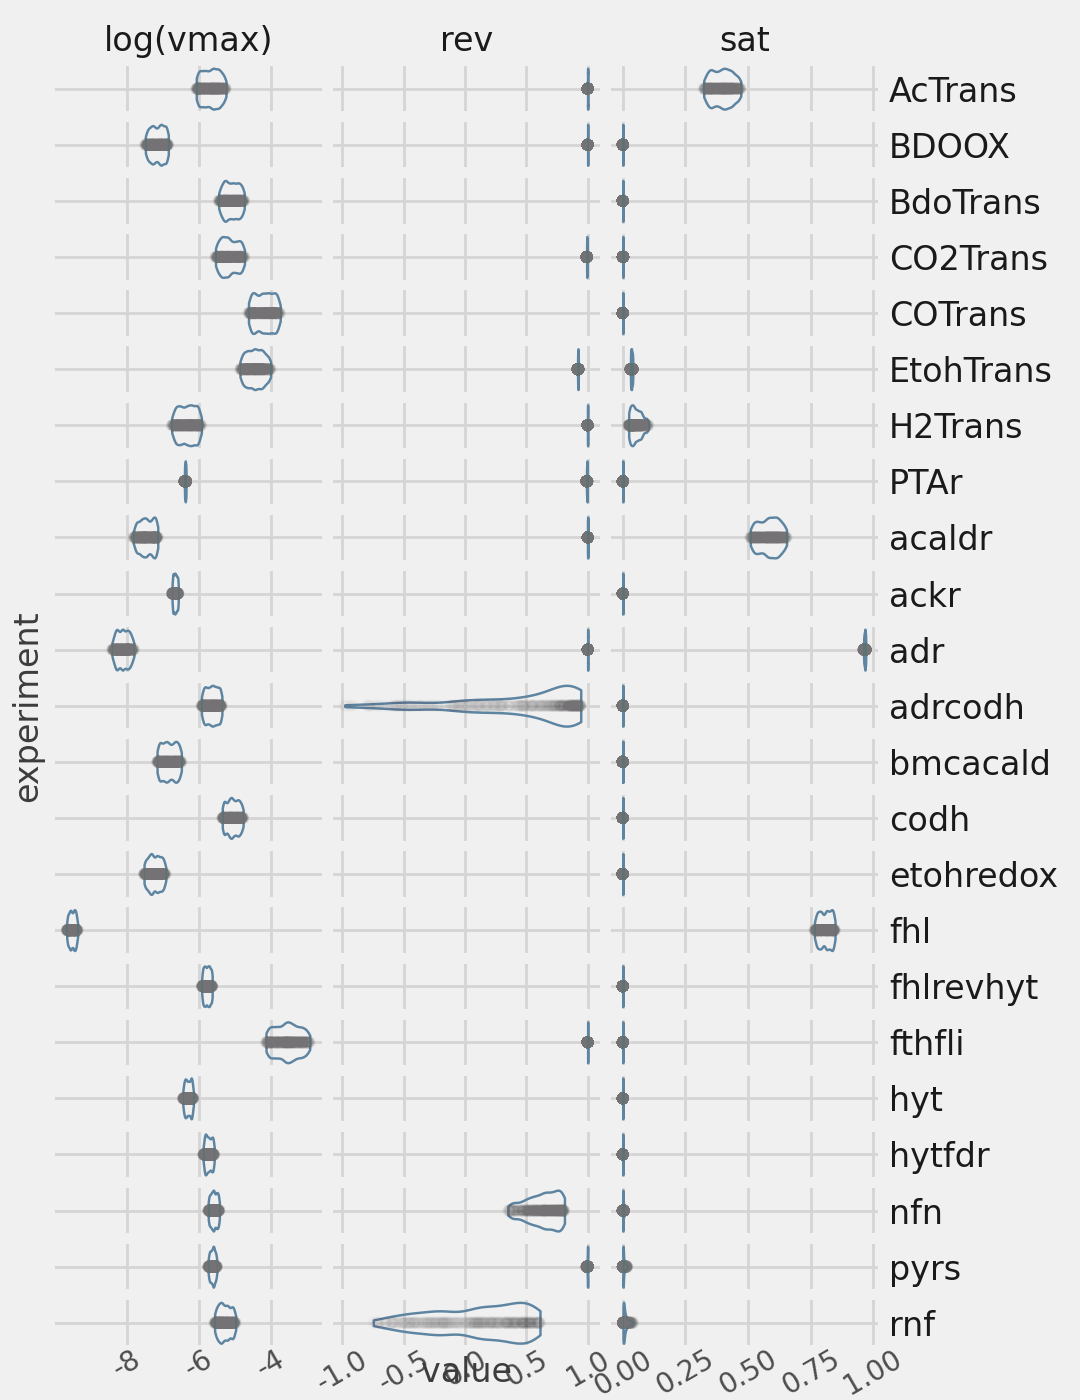

In [24]:
pred_fluxmod_plot = (
    ggplot(
        flux_df[
            ((flux_df.value > -1) | (flux_df.module != "rev"))
            & (flux_df.module.isin(["rev", "log(vmax)", "sat"]))
        ],
        aes(
            x="experiment",
            y="value",
            color="kind",
        ),
    )
    + geom_violin(scale="width", fill="none", color="#5d85a2")
    + geom_point(alpha=0.01, color="#757275")
    + coord_flip()
    + facet_grid("reaction ~ module", scales="free_x")
    + theme_538()
    # + theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(
        figure_size=(5.4, 7),
        strip_text=element_text(size=12, rotation=0),
        axis_text_x=element_text(size=10, rotation=30),
        axis_text_y=element_blank(),
        axis_title=element_text(size=12),
        strip_background=element_rect(
            fill="#f0f0f0",
            color="#d5d5d5",
        ),
    )
)
pred_fluxmod_plot

In [54]:
import numpy as np

In [ ]:
flux_df["mlog-value"] = np.sign(flux_df["value"]) * np.log10(np.abs(flux_df["value"]))

In [60]:
reac_meas["mlog-value"] = np.sign(reac_meas["value"]) * np.log10(np.abs(reac_meas["value"]))

In [62]:
reac_meas["mlog-down"] = np.sign(reac_meas["down"]) * np.log10(np.abs(reac_meas["down"]))
reac_meas["mlog-up"] = np.sign(reac_meas["up"]) * np.log10(np.abs(reac_meas["up"]))

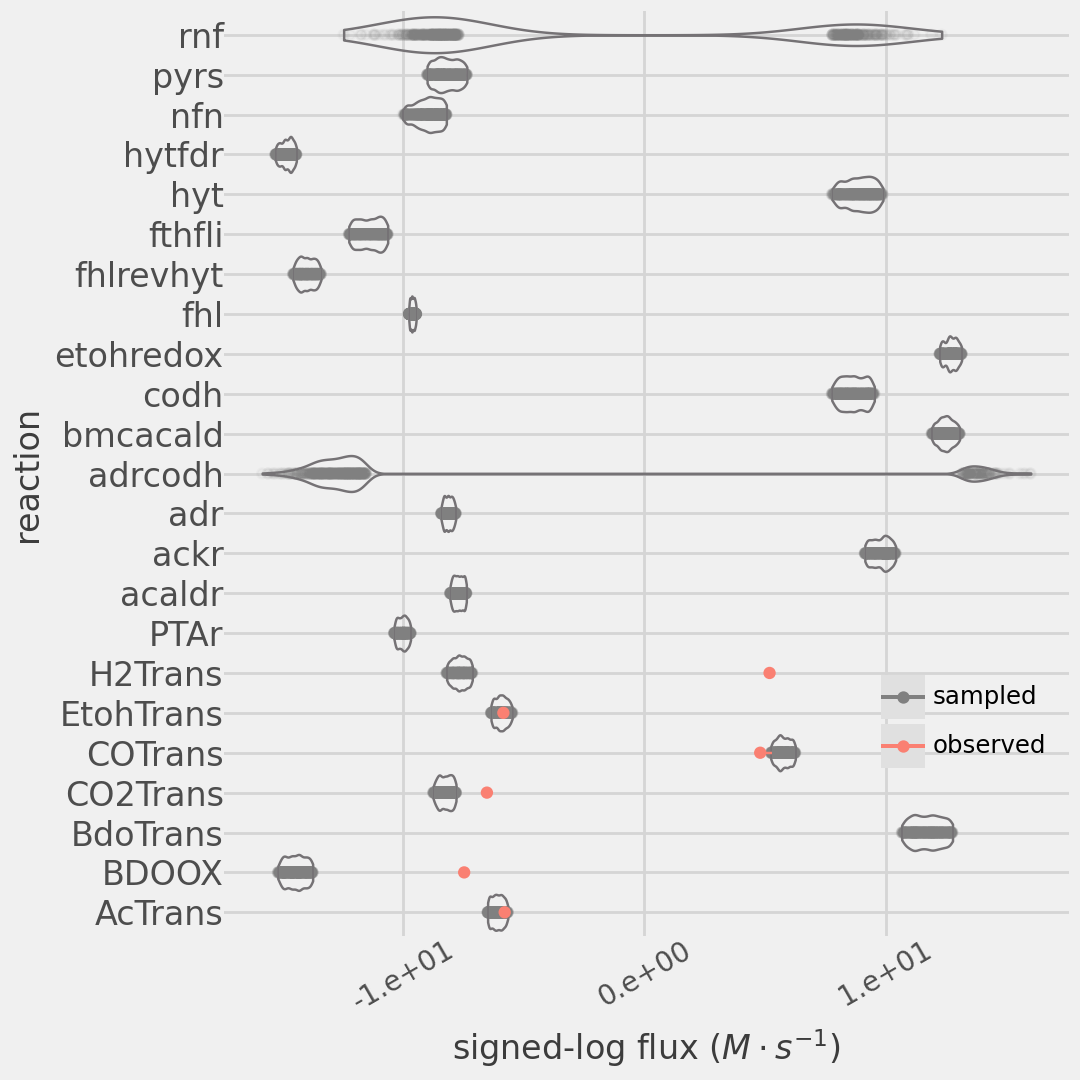

In [75]:
from mizani.formatters import scientific_format

pred_onlyflux_plot = (
    ggplot(
        flux_df[flux_df.module == "flux"],
        aes(
            x="reaction",
            y="mlog-value",
            color="kind",
        ),
    )
    + geom_violin(scale="width", fill="none", color="#757275")
    + geom_jitter(alpha=0.05, width=0, height=0)
    + geom_point(data=reac_meas)
    + geom_linerange(mapping=aes(ymin="mlog-down", ymax="mlog-up"), data=reac_meas)
    + coord_flip()
    #+ facet_wrap("~reaction", scales="free_x", ncol=6)
    + theme_538()
    # + theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(
        figure_size=(5.4, 5.4),
        strip_text=element_text(size=12),
        axis_text_x=element_text(size=10, rotation=30),
        axis_text_y=element_text(size=12),
        axis_title=element_text(size=12),
        legend_title=element_blank(),
        legend_position=(0.97,0.2),
        strip_background=element_rect(
            fill="#f0f0f0",
            color="#f0f0f0",
        ),
    )
    + ylab(r"signed-log flux ($M \cdot s^{-1}$)")
    + scale_color_manual(["gray", "salmon"])
    + scale_y_continuous(labels=scientific_format(digits=2))
)
pred_onlyflux_plot

In [47]:
conc_output = []
for var_name, dfs in across_exps.items():
    if "conc" in var_name:
        for df in dfs:
            df["kind"] = var_name
        conc_output.append(pd.concat(dfs))
conc_df = pd.concat(conc_output)

In [48]:
conc_df = conc_df.melt(id_vars=["experiment", "kind"], var_name="metabolite")

In [49]:
conc_df.loc[conc_df.kind == "ln_bal_conc", "value"] = np.exp(
    conc_df.loc[conc_df.kind == "ln_bal_conc", "value"]
)
conc_df.loc[conc_df.kind == "ln_bal_conc_q", "value"] = np.exp(
    conc_df.loc[conc_df.kind == "ln_bal_conc_q", "value"]
)

In [50]:
from maud.getting_idatas import MeasurementType

mics_measurements = {
    (exp.id, f"{meas.metabolite}_{meas.compartment}"): (meas.value, meas.error_scale)
    for exp in maudy.maud_params.experiments
    for meas in exp.measurements
    if meas.target_type == MeasurementType.MIC
}
conc_meas = [list(keys) + list(val) for keys, val in mics_measurements.items()]
conc_meas = pd.DataFrame(
    conc_meas, columns=["experiment", "metabolite", "exploc", "scale"]
)
conc_meas["up"] = np.exp(np.log(conc_meas["exploc"]) + 1.96 * conc_meas["scale"])
conc_meas["down"] = np.exp(np.log(conc_meas["exploc"]) - 1.96 * conc_meas["scale"])
conc_meas["kind"] = "observed"
conc_meas["value"] = conc_meas["exploc"]

In [51]:
maudy.unb_conc_loc
maudy.unb_conc_scale

tensor([[0.0981, 0.4235, 0.3020, 0.4302, 0.0084, 0.0484, 1.6337, 1.1388, 0.4300,
         2.0000]])

In [52]:
conc_df["kind"] = (
    conc_df["kind"]
    .str.replace("ln_bal_conc_q", r"$e^{NN + q}$")
    .str.replace("ln_bal_conc", r"$e^{NN}$ balanced loc")
    .str.replace("bal_conc", "[balanced]")
    .str.replace("unb_conc", "[unbalanced]")
)
conc_meas["kind"] = (
    conc_meas["kind"]
    .str.replace("ln_bal_conc_q", r"$e^{NN + q}$")
    .str.replace("ln_bal_conc", r"$e^{NN}$ balanced loc")
    .str.replace("bal_conc", "[balanced]")
    .str.replace("unb_conc", "[unbalanced]")
)

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 35000 rows containing missing values.


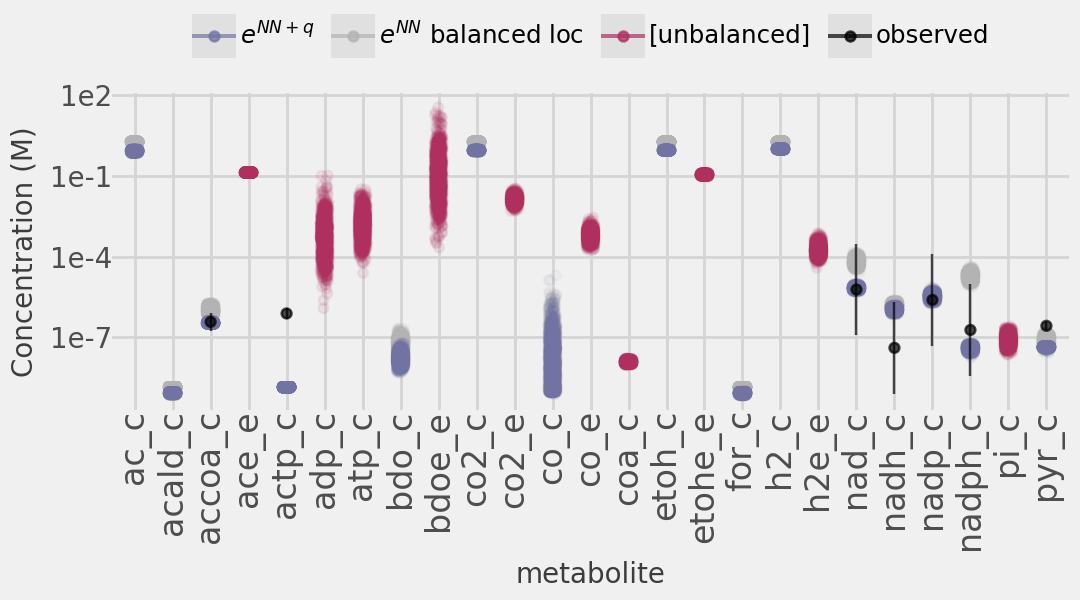

In [73]:
linear_plot = (
    ggplot(
        conc_df,
        aes(
            x="metabolite",
            y="value",
            # color="kind",
            color="kind",
        ),
    )
    + geom_jitter(
        data=conc_df[conc_df.kind != "ln_bal_conc"], alpha=0.08, width=0.1, height=0
    )
    + geom_jitter(
        data=conc_df[conc_df.kind == "ln_bal_conc"], alpha=0.08, width=0.1, height=0
    )
    + geom_linerange(data=conc_meas, mapping=aes(ymin="down", ymax="up"), alpha=0.7)
    + geom_point(data=conc_meas, alpha=0.7)
    + scale_y_log10()
    + theme_538()
    # + theme(figure_size=(20, 10), plot_background=element_rect(fill="white"))
    + theme(
        figure_size=(5.4, 3),
        strip_text=element_text(size=12),
        legend_title=element_blank(),
        legend_position="top",
        axis_text_y=element_text(size=10),
        axis_text_x=element_text(size=12, rotation=90),
        axis_title=element_text(size=10),
        strip_background=element_rect(
            fill="#f0f0f0",
            color="#f0f0f0",
            size=0.5,
        ),
    )
    # + scale_color_manual(["gray", "red", "black"])
    + scale_color_manual(["#7373a3", "#b3b3b3", "#af2f5f", "black"])
    + ylab("Concentration (M)")
)
linear_plot

This is the (model) ssd for a run trained with half the samples.

In [76]:
#linear_flux_plot.save("cauto_flux_terms_three_conds.tiff", dpi=300)
pred_onlyflux_plot.save("cauto_onlyflux_syngas_oos_quench.tiff", dpi=300)
linear_plot.save("conc_syngas_oos_quench.tiff", dpi=300)

/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5.4 x 5.4 in image.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: cauto_onlyflux_syngas_oos_quench.tiff
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 5.4 x 3 in image.
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: conc_syngas_oos_quench.tiff
/home/georg/git/maudy/.venv/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 35000 rows containing missing values.
